# TIØ4317 - Empirical and Quantitative Methods in Finance Project 

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import DFGLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm

In [ ]:
ticker_Bitcoin = yf.Ticker("BTC-USD")  
df_Bitcoin = ticker_Bitcoin.history(period="5y")  

ticker_Bitcoin_Cash = yf.Ticker("BCH-USD")  
df_Bitcoin_Cash = ticker_Bitcoin_Cash.history(period="5y")  


In [ ]:
# Data cleaning for Bitcoin
print("Datafile head: \n", df_Bitcoin.head())       
print("Checking for null values:")       
print( df_Bitcoin.info())
print("Statistical precentiles: \n", df_Bitcoin.describe())


In [ ]:
# Data cleaning for Bitcoin Cash
print("Datafile head: \n", df_Bitcoin_Cash.head())       
print("Checking for null values:")       
print( df_Bitcoin_Cash.info())    
print("Statistical precentiles: \n", df_Bitcoin_Cash.describe())   

In [ ]:
# Plotting closing prices for each day the last 5 years

# Plot for Bitcoin
plt.figure(figsize=(12, 6))
plt.plot(df_Bitcoin.index, df_Bitcoin["Close"], label="Bitcoin Close Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("Bitcoin - Close Price for the Last 5 Years")
plt.legend()
plt.grid()
plt.show()

# Plot for Bitcoin Cash
plt.figure(figsize=(12, 6))
plt.plot(df_Bitcoin_Cash.index, df_Bitcoin_Cash["Close"], label="Bitcoin Cash Close Price", color="green")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("Bitcoin Cash - Close Price for the Last 5 Years")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Add a constant (intercept) to the Bitcoin prices for the regression
X = sm.add_constant(df_Bitcoin['Close'])  # This adds the intercept term to the model
y = df_Bitcoin_Cash['Close']

# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression summary
print(results.summary())

intercept = results.params[0]
beta = results.params[1]

# Compute the price spread
price_spread = df_Bitcoin_Cash['Close'] - (intercept + beta * df_Bitcoin['Close'])

# Create the new DataFrame
spread_df = pd.DataFrame({'price_spread': price_spread})

# Check results
print(spread_df.head())
print("Mean spread:", spread_df['price_spread'].mean())

In [ ]:
# ADF Test for bitcoin Log return in closing price
adf_btc_c_log_return = adfuller(spread_df['price_spread'].dropna(), maxlag=10, regression='c')
print("\nADF Test for Log return in bitcoin cash closing price:")
print("Test Statistic:", adf_btc_c_log_return[0])
print("p-value:", adf_btc_c_log_return[1])
print("Critical Values:", adf_btc_c_log_return[4])

In [ ]:
# Plot ACF Bitcoin
plt.figure(figsize=(12,6))
plot_acf(spread_df['price_spread'], lags=40, ax=plt.gca(), zero=False)
plt.title('Bitcoin Autocorrelation Function (ACF)')
plt.show()

# Plot PACF Bitcoin
plt.figure(figsize=(12,6))
plot_pacf(spread_df['price_spread'], lags=40, ax=plt.gca(), zero=False)
plt.title('Bitcoin Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
# Initialize AIC and BIC tables (6x6 matrices)
aic_table = np.full((6, 6), np.nan)  # AIC values
bic_table = np.full((6, 6), np.nan)  # BIC values

# Fit ARIMA models for different (p, d=0, q) combinations
for ar in range(6):
    for ma in range(6):
        try:
            model = ARIMA(spread_df["price_spread"], order=(ar, 0, ma))
            fitted_model = model.fit()
            print(fitted_model.llf)
            print(fitted_model.df_model)
            aic_table[ar, ma] = fitted_model.aic  # Store AIC
            bic_table[ar, ma] = fitted_model.bic  # Store BIC
        except:
            # In case of a model fitting error, we skip this combination
            pass

# Display AIC and BIC tables
print("AIC Table:\n", aic_table)
print("\nBIC Table:\n", bic_table)

# Find the (p, q) combination with the lowest AIC
min_aic_index = np.unravel_index(np.nanargmin(aic_table), aic_table.shape)
min_bic_index = np.unravel_index(np.nanargmin(bic_table), bic_table.shape)

print(f"\nBest ARMA(p,q) for AIC: p={min_aic_index[0]}, q={min_aic_index[1]}")
print(f"Best ARMA(p,q) for BIC: p={min_bic_index[0]}, q={min_bic_index[1]}")

## Forecasting

In [ ]:
forecast_steps = 10
forecasts = []

for i in range(0, 140):
    spread_estimation = spread_df["price_spread"].iloc[:-150+i]  # Exclude the last 150 days for testing
    btc_model = ARIMA(spread_estimation, order=(3, 0, 3))
    fitted_btc_model = btc_model.fit()
    forecast = fitted_btc_model.forecast(steps=forecast_steps)
    forecasts.append(forecast[-1])

## Trading Trial

Forecasts:  140
Spread trading:  140
Cumulative perfect trading signal:  5398.986725310112
Cumulative profit:  -1120.7388141534493
Final profit:  -1120.7388141534493


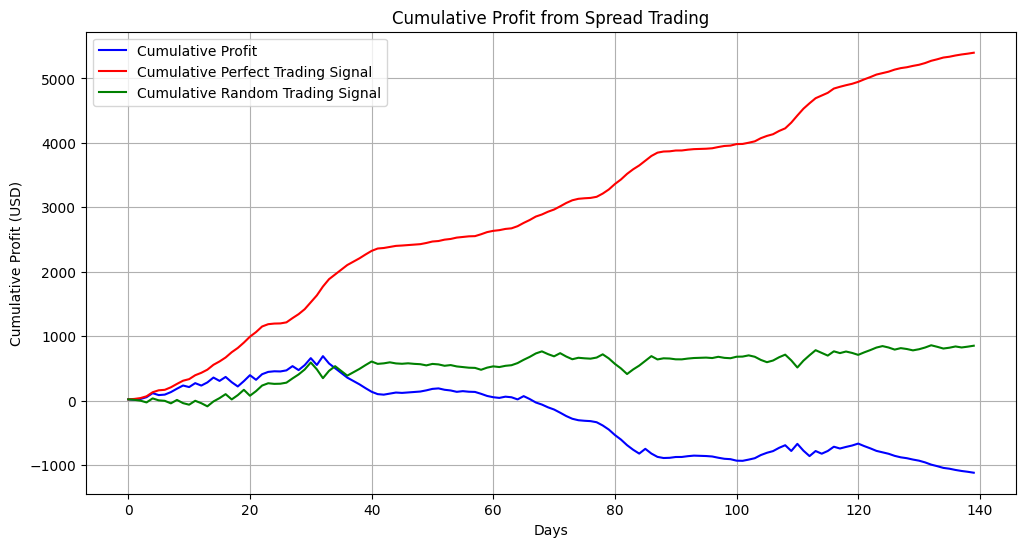

In [ ]:
spread_trading = spread_df["price_spread"].iloc[-150:-10]  # Last 150 days for testing
trade_results = spread_df["price_spread"].iloc[-140:]  # Last 150 days for testing

print("Forecasts: ", len(forecasts))
print("Spread trading: ", len(spread_trading))

# List, 1 for buy, -1 for sell, 0 for hold if forecasts[i] > spread_trading.iloc[i] else -1
trading_signal = []
for i in range(len(forecasts)):
    if forecasts[i] > spread_trading.iloc[i]:
        trading_signal.append(1)  # Buy
    elif forecasts[i] < spread_trading.iloc[i]:
        trading_signal.append(-1)  # Sell
    else:
        trading_signal.append(0)  # Hold

spread_movement = np.array(trade_results) - np.array(spread_trading)
perfect_trading_signal = np.abs(spread_movement)
cumulative_perfect_trading_signal = np.cumsum(perfect_trading_signal)
print("Cumulative perfect trading signal: ", cumulative_perfect_trading_signal[-1])
random_trading_signal = np.random.choice([-1, 1], size=len(trading_signal), p=[0.5, 0.5])
random_trading_signal_profit = random_trading_signal * spread_movement
cumulative_random_trading_signal = np.cumsum(random_trading_signal_profit)

trading_profit = trading_signal * spread_movement
cumulative_profit = np.cumsum(trading_profit)
print("Cumulative profit: ", cumulative_profit[-1])
print("Final profit: ", cumulative_profit[-1])
plt.figure(figsize=(12, 6))
plt.plot(cumulative_profit, label="Cumulative Profit", color="blue")
plt.plot(cumulative_perfect_trading_signal, label="Cumulative Perfect Trading Signal", color="red")
plt.plot(cumulative_random_trading_signal, label="Cumulative Random Trading Signal", color="green")
plt.xlabel("Days")
plt.ylabel("Cumulative Profit (USD)")
plt.title("Cumulative Profit from Spread Trading (USD)")
plt.legend()
plt.grid()
plt.show()
# Calculate performance metrics
mse = mean_squared_error(trade_results, forecasts)
mae = mean_absolute_error(trade_results, forecasts)
mape = mean_absolute_percentage_error(trade_results, forecasts)



# Spread Trading Forecast Performance Summary

This analysis evaluates a spread trading strategy using an ARIMA-based forecast model over **140 trading days**. The strategy's performance is benchmarked against a **perfect foresight strategy** and a **random signal baseline**.

---

### Results

- **Number of forecasts:** 140  
- **Cumulative profit (Perfect Trading Signal):** \$5,398.99  
- **Cumulative profit (Forecast-Based Strategy):** **- \$1,120.74**  


---

### Strategy Comparison

| Strategy                      | Cumulative Profit (USD) | Performance Summary                                             |
|------------------------------|--------------------------|------------------------------------------------------------------|
| 🔴 Perfect Trading Signal     | \$5,398.99               | Ideal scenario with future knowledge – sets the upper benchmark. |
| 🔵 Forecast-Based Strategy    | - \$1,120.74        | Model underperforms significantly; potential for improvement.     |
| 🟢 Random Trading Signal      | ~Flat                    | Serves as a noise-level baseline; outperformed the model here.    |

---

### Insights

- The ARIMA model underperformed, especially after day 40, suggesting forecast decay or misalignment with spread dynamics.
- The large gap between perfect foresight and actual performance implies room for model improvement.
- Possible next steps:
  - Introduce volatility filters or signal thresholds
  - Use walk-forward retraining
  - Explore machine learning or regime-switching models

---

### Conclusion

The current ARIMA-based strategy does not generate profitable trading signals in this setting. Enhancing the model’s ability to capture the underlying spread behavior will be essential for real-world deployment.
